In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = np.load('../data/dataset-C4-depth1/training-validation.npz')

In [3]:
X_train, y_train = train_data['X_train'], train_data['y_train']

In [4]:
X_train.shape

(56288, 33)

In [5]:
y_train.shape

(56288, 3)

In [6]:
# Split the data to training - validation (not testing yet!)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
X_train.shape

(45030, 33)

In [8]:
X_val.shape

(11258, 33)

# Extract relative coordinates from input vector

In [11]:
X_val_coords = extract_relative_coordinates(X_val)

In [33]:
X_val[0]

array([ 0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,
       -1.329,  0.148, -0.242,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
        1.   ,  0.   ,  0.   ,  0.514, -1.416, -0.026,  0.   ,  0.   ,
        0.   ,  1.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.73 ,  0.66 ,
       -1.098])

In [35]:
X_val_coords[0]

[[-1.3289999999999997, 0.1479999999999997, -0.2419999999999991],
 [0.5139999999999998, -1.4160000000000004, -0.0259999999999998],
 [0.73, 0.6600000000000001, -1.0980000000000008]]

# Evaluation scheme for regression
- uses methods from ```evaluation.py```

In [9]:
from evaluation import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [10]:
def eval_regression(y_test, y_pred):
    print("Alle folgenden Metriken sind H zu H'")
    # absoluter Abstand H zu H' (MSE Score)
    mse = mean_squared_error(y_test, y_pred)
    print("Mittlerer Abstand: ", mse)

    # R2 Bestimmtheitskoeffizient
    r2 = r2_score(y_test, y_pred)
    print("R2 Bestimmtheitsmaß: ", r2)

    # Durchschnittliche Cosine Similarity (kann ignoriert werden) und durchschnittliche Winkel
    avg_cosine_similarity, avg_angle = metric_cosine_similarity_and_angle(y_test, y_pred)
    print("Average Cosine Similarity: ", avg_cosine_similarity)
    print("Average Angle (degrees): ", avg_angle)

    # Duchschnittliche Bindungslängendifferenz
    avg_bindugslänge_diff = metric_bindungslänge_differenz(y_test, y_pred)
    print("Durschnittliche Bindungslänge Differenz: ", avg_bindugslänge_diff)

    return mse, r2, avg_angle, avg_bindugslänge_diff

# Linear regression models
- <span style="color:red">worse than all results of tree-based models / bagging and boosting models</span>

In [93]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.multioutput import MultiOutputRegressor

## Normal linear regression

In [113]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

In [114]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.01850408424793057
R2 Bestimmtheitsmaß:  0.9542518778589825
Average Cosine Similarity:  0.9867936578433114
Average Angle (degrees):  5.370116450524072
Durschnittliche Bindungslänge Differenz:  0.03732114580310908


### mit vorsicht zu genießen, da die Größe der LG coefficients nicht unbedingt was über wichtigkeit aussagt

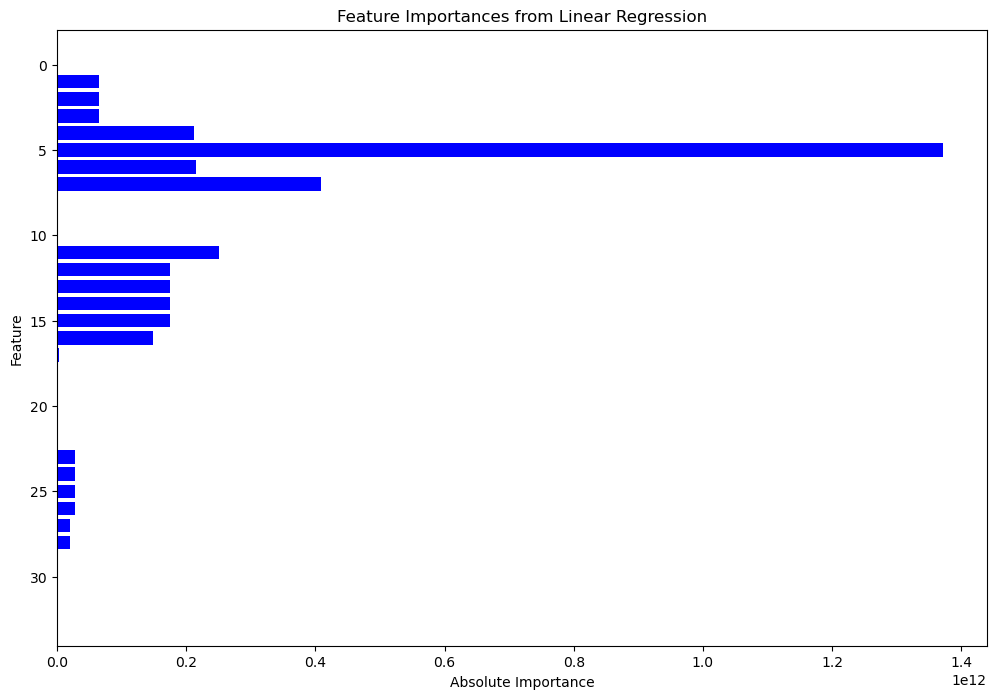

In [116]:
# Get feature importances (coefficients)
coefficients = model.coef_

# If y_train is multidimensional (multi-output regression), average the coefficients
if coefficients.ndim > 1:
    coefficients = np.mean(coefficients, axis=0)

# Create a DataFrame for plotting
feature_importances_df = pd.DataFrame({
    'Feature': range(X_train.shape[1]),
    'Importance': coefficients
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], abs(feature_importances_df['Importance']), color='b')
plt.xlabel('Absolute Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Linear Regression')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

## Ridge

In [98]:
# Initialize the base Ridge model
ridge_base = Ridge(alpha=0.001)

# Wrap the Ridge model with MultiOutputRegressor
ridge_model = MultiOutputRegressor(ridge_base)

# Train the model
ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge_model.predict(X_val)

In [99]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.01850433739103999
R2 Bestimmtheitsmaß:  0.954251329913477
Average Cosine Similarity:  0.9867918813288328
Average Angle (degrees):  5.369337271273761
Durschnittliche Bindungslänge Differenz:  0.03736686440193582


## Lasso

In [104]:
# Initialize the base Lasso model
lasso_base = Lasso(alpha=0.001)

# Wrap the Lasso model with MultiOutputRegressor
lasso_model = MultiOutputRegressor(lasso_base)

# Train the model
lasso_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lasso_model.predict(X_val)

In [105]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.018489429116966747
R2 Bestimmtheitsmaß:  0.9542883606452217
Average Cosine Similarity:  0.9869930715935334
Average Angle (degrees):  5.358137591046367
Durschnittliche Bindungslänge Differenz:  0.043479056657394155


## Polynomial Regression (does not make sense for our features and is not good neither)

In [120]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial regression of order 2
poly2 = PolynomialFeatures(degree=2)
X_train_poly2 = poly2.fit_transform(X_train)
X_val_poly2 = poly2.transform(X_val)

#### interesting: does not work at all for LinearRegression only

In [129]:
# Wrap the Lasso model with MultiOutputRegressor
model_poly2 = LinearRegression()

# Fit the model
model_poly2.fit(X_train_poly2, y_train)

# Predict on the test set
y_pred = model_poly2.predict(X_val_poly2)

In [130]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  3.2592404282219663e+19
R2 Bestimmtheitsmaß:  -8.002710306781071e+19
Average Cosine Similarity:  0.9876282643453544
Average Angle (degrees):  4.896006928406466
Durschnittliche Bindungslänge Differenz:  142273033.87208986


In [127]:
# Initialize the base Lasso model
lasso_base = Lasso(alpha=0.001)

# Wrap the Lasso model with MultiOutputRegressor
model_poly2 = MultiOutputRegressor(lasso_base)

# Fit the model
model_poly2.fit(X_train_poly2, y_train)

# Predict on the test set
y_pred = model_poly2.predict(X_val_poly2)

In [128]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.01746251415934664
R2 Bestimmtheitsmaß:  0.9568367436662428
Average Cosine Similarity:  0.9879329365784332
Average Angle (degrees):  4.9001554450168765
Durschnittliche Bindungslänge Differenz:  0.04195485269520716


In [123]:
# Initialize the base Lasso model
ridge_base = Ridge(alpha=0.01)

# Wrap the Lasso model with MultiOutputRegressor
model_poly2 = MultiOutputRegressor(ridge_base)

# Fit the model
model_poly2.fit(X_train_poly2, y_train)

# Predict on the test set
y_pred = model_poly2.predict(X_val_poly2)

In [124]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.017086957440561597
R2 Bestimmtheitsmaß:  0.9577686052821512
Average Cosine Similarity:  0.9880569372890391
Average Angle (degrees):  4.861379552318352
Durschnittliche Bindungslänge Differenz:  0.034469559827688734


# Tree-based models / Bagging and boosing models

## Random Forest regressor

In [68]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_val)

In [27]:
metrics = eval_regression(y_val, y_pred)

Mittlerer Abstand H zu H':  0.008104933891924198
R2 Bestimmtheitsmaß H zu H':  0.9799739308777223
Average Cosine Similarity:  0.9894434180138568
Average Angle (degrees):  4.002159264523007
Durschnittliche Bindungslänge Differenz:  0.04858697825523639


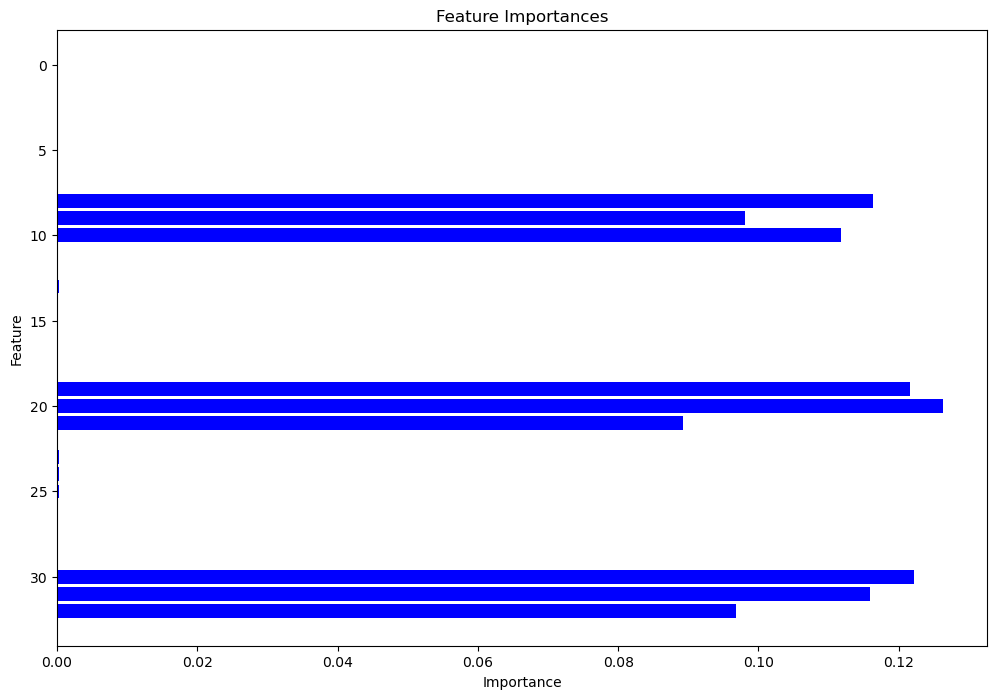

In [75]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for plotting
feature_importances_df = pd.DataFrame({
    'Feature': range(X_train.shape[1]),
    'Importance': feature_importances
})

# Sort the DataFrame by importance
# feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='b')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

## Gradient Boosting regressor
- old: Gradient Boosting Multi-Output R² score: 0.8516877707002646

In [76]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the base model
base_gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Wrap the base model with MultiOutputRegressor
multi_gb_model = MultiOutputRegressor(base_gb_model)

# Train the model
multi_gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_gb_model.predict(X_val)

In [48]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.015167419744276253
R2 Bestimmtheitsmaß:  0.9625185675012967
Average Cosine Similarity:  0.9857761591756972
Average Angle (degrees):  6.666454965357968
Durschnittliche Bindungslänge Differenz:  0.04240796404098801


In [36]:
all_angles = all_angles_H_central_neighbor(X_val_coords, y_pred)

In [46]:
# Fit a Gaussian (normal distribution) to the data
mu, std = norm.fit(all_angles)
print(f"Single Gaussian parameters: mu={mu}, sigma={std}")

Single Gaussian parameters: mu=109.06204176926043, sigma=7.448510072185309


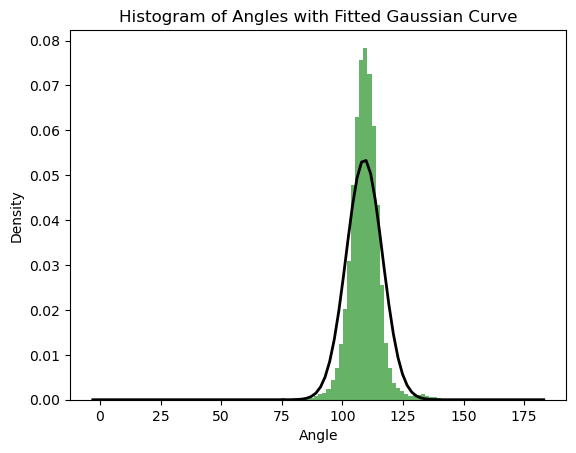

In [43]:
# Plot histogram of angles
count, bins, ignored = plt.hist(all_angles, bins=100, density=True, alpha=0.6, color='g')

# Plot the Gaussian curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add labels and title
plt.xlabel('Angle')
plt.ylabel('Density')
plt.title('Histogram of Angles with Fitted Gaussian Curve')

# Show plot
plt.show()

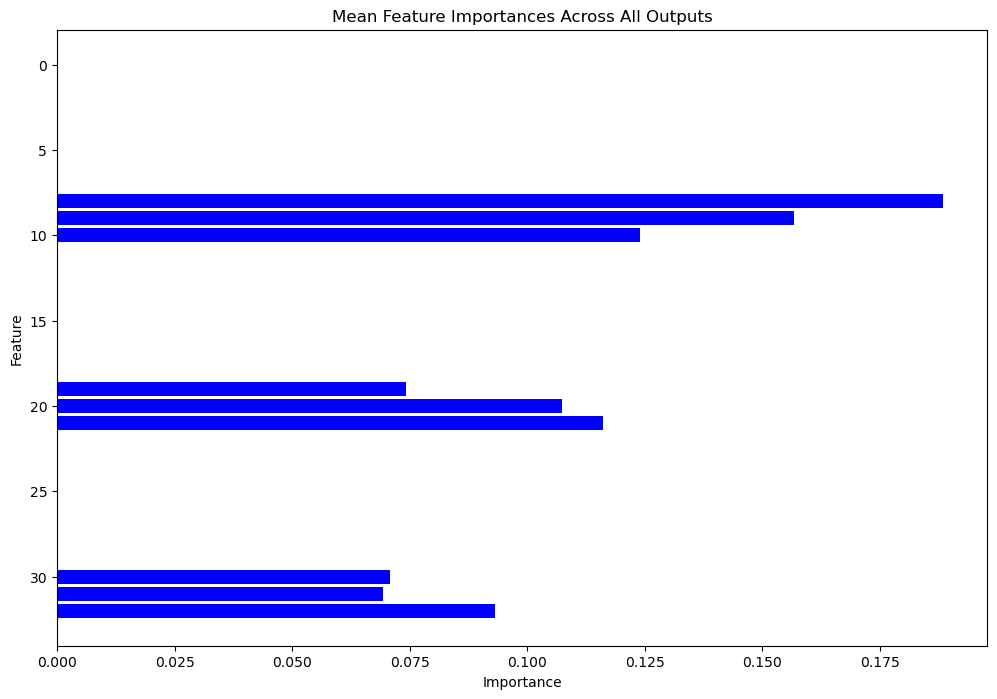

In [85]:
# Get feature importances from each model
feature_importances_list = []
for model in multi_gb_model.estimators_:
    feature_importances_list.append(model.feature_importances_)

# Convert to DataFrame for easier manipulation
feature_importances_df = pd.DataFrame(feature_importances_list, columns=range(X_train.shape[1]))

# Calculate mean feature importance across all output models
mean_feature_importances = feature_importances_df.mean(axis=0)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Feature': range(X_train.shape[1]),
    'Importance': mean_feature_importances
})

# Sort the DataFrame by importance
#plot_df = plot_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_df['Feature'], plot_df['Importance'], color='b')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Mean Feature Importances Across All Outputs')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

## Support Vector Regressor (SVR)
- <span style="color:red">a bit slower than the other methods</span>
- <span style="color:green">but very good results</span>

In [86]:
from sklearn.svm import SVR

# Initialize the base model
base_svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Wrap the base model with MultiOutputRegressor
multi_svr_model = MultiOutputRegressor(base_svr_model)

# Train the model
multi_svr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_svr_model.predict(X_val)

In [55]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.008767961680048111
R2 Bestimmtheitsmaß:  0.9783272645585465
Average Cosine Similarity:  0.9922471131639724
Average Angle (degrees):  3.546587404512347
Durschnittliche Bindungslänge Differenz:  0.023396826801598936


In [56]:
all_angles = all_angles_H_central_neighbor(X_val_coords, y_pred)

In [57]:
# Fit a Gaussian (normal distribution) to the data
mu, std = norm.fit(all_angles)
print(f"Single Gaussian parameters: mu={mu}, sigma={std}")

Single Gaussian parameters: mu=109.02432860660356, sigma=5.7018650621644635


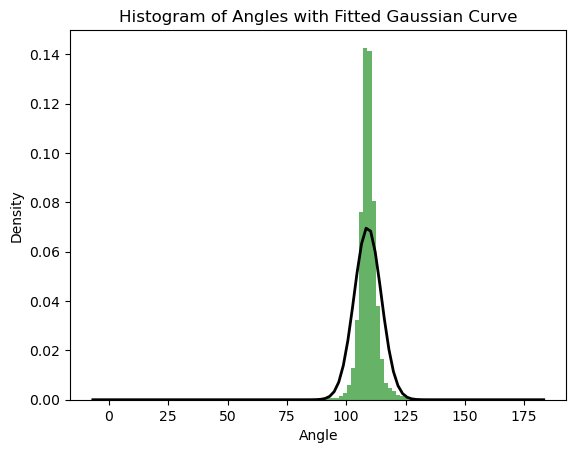

In [58]:
# Plot histogram of angles
count, bins, ignored = plt.hist(all_angles, bins=100, density=True, alpha=0.6, color='g')

# Plot the Gaussian curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add labels and title
plt.xlabel('Angle')
plt.ylabel('Density')
plt.title('Histogram of Angles with Fitted Gaussian Curve')

# Show plot
plt.show()

## XGBoost Regressor
- <span style="color:green">extremely fast</span>
- <span style="color:red">not the best results</span>

In [ ]:
#!pip install xgboost

In [87]:
import xgboost as xgb

# Initialize the model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_val)

In [88]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.010391334037374573
R2 Bestimmtheitsmaß:  0.9743202092950858
Average Cosine Similarity:  0.986642742938355
Average Angle (degrees):  5.345542813998934
Durschnittliche Bindungslänge Differenz:  0.014871523978634116


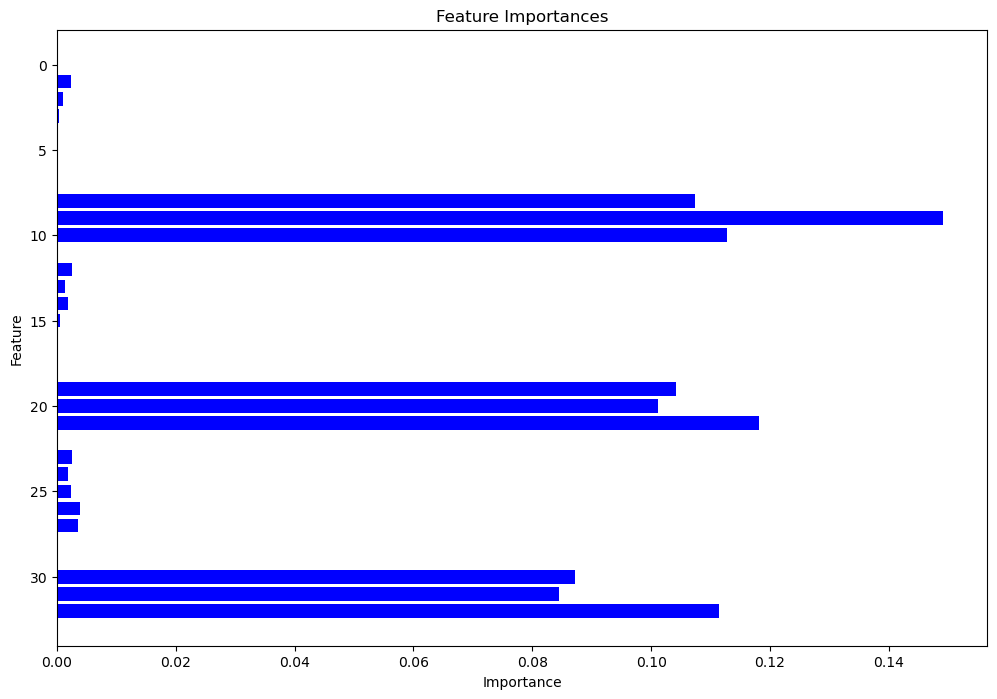

In [89]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for plotting
feature_importances_df = pd.DataFrame({
    'Feature': range(X_train.shape[1]),
    'Importance': feature_importances
})

# Sort the DataFrame by importance
# feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='b')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

## CatBoost Regressor
- <span style="color:green">extremely fast</span>
- <span style="color:red">not the best results</span>

In [14]:
#!pip install catboost

   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB 435.7 kB/s eta 0:03:53
   ---------------------------------------- 0.1/101.1 MB 1.0 MB/s eta 0:01:39
   ---------------------------------------- 0.4/101.1 MB 2.6 MB/s eta 0:00:39
   ---------------------------------------- 0.8/101.1 MB 3.9 MB/s eta 0:00:26
    --------------------------------------- 1.3/101.1 MB 5.3 MB/s eta 0:00:19
    --------------------------------------- 1.9/101.1 MB 6.5 MB/s eta 0:00:16
   - -------------------------------------- 2.6/101.1 MB 7.4 MB/s eta 0:00:14
   - -------------------------------------- 3.2/101.1 MB 8.0 MB/s eta 0:00:13
   - -------------------------------------- 3.8/101.1 MB 8.6 MB/s eta 0:00:12
   - -------------------------------------- 4.4/101.1 MB 9.0 MB/s eta 0:00:11
   - -------------------------------------- 5.0/101.1 MB 9.4 MB/s eta 0:00:1

In [90]:
from catboost import CatBoostRegressor

# Initialize the base model
base_cat_model = CatBoostRegressor(iterations=100, random_state=42, verbose=0)

# Wrap the base model with MultiOutputRegressor
multi_cat_model = MultiOutputRegressor(base_cat_model)

# Train the model
multi_cat_model.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_cat_model.predict(X_val)

In [65]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.011555635133231124
R2 Bestimmtheitsmaß:  0.9714355294284159
Average Cosine Similarity:  0.9874308047610587
Average Angle (degrees):  5.400434357790016
Durschnittliche Bindungslänge Differenz:  0.018880497356522197


In [66]:
all_angles = all_angles_H_central_neighbor(X_val_coords, y_pred)

In [67]:
# Fit a Gaussian (normal distribution) to the data
mu, std = norm.fit(all_angles)
print(f"Single Gaussian parameters: mu={mu}, sigma={std}")

Single Gaussian parameters: mu=109.05001059064347, sigma=6.874995082375959


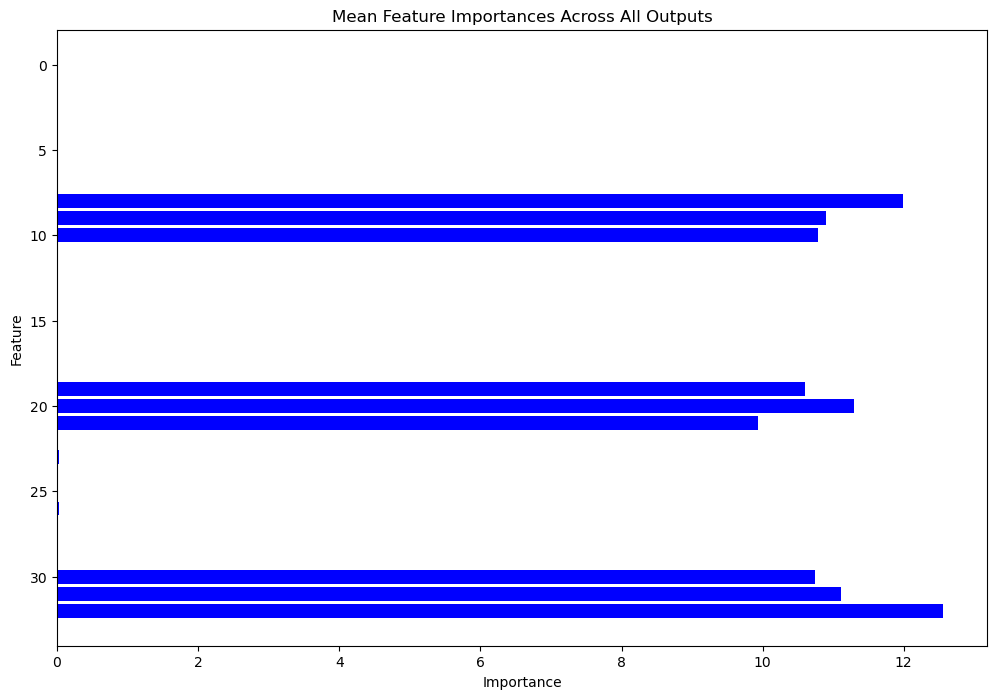

In [91]:
# Get feature importances from each model
feature_importances_list = []
for model in multi_cat_model.estimators_:
    feature_importances_list.append(model.feature_importances_)

# Convert to DataFrame for easier manipulation
feature_importances_df = pd.DataFrame(feature_importances_list, columns=range(X_train.shape[1]))

# Calculate mean feature importance across all output models
mean_feature_importances = feature_importances_df.mean(axis=0)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Feature': range(X_train.shape[1]),
    'Importance': mean_feature_importances
})

# Sort the DataFrame by importance
#plot_df = plot_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_df['Feature'], plot_df['Importance'], color='b')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Mean Feature Importances Across All Outputs')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

# Bayesian Regression 

In [132]:
from sklearn.linear_model import BayesianRidge

bayesian_ridge_model = BayesianRidge()
multi_bayesian_ridge_model = MultiOutputRegressor(bayesian_ridge_model)
multi_bayesian_ridge_model.fit(X_train, y_train)
y_pred = multi_bayesian_ridge_model.predict(X_val)

In [133]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.018500848334653226
R2 Bestimmtheitsmaß:  0.9542599542441482
Average Cosine Similarity:  0.986794279623379
Average Angle (degrees):  5.369067241073015
Durschnittliche Bindungslänge Differenz:  0.037390724066073355


# Neural Networks

In [ ]:
# For GPU users
#pip install tensorflow[and-cuda]

## Simple MLP

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

In [27]:
model = Sequential()
model.add(Dense(input_dim, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(output_dim))

In [28]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 33)                1122      
                                                                 
 dense_13 (Dense)            (None, 16)                544       
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 dense_15 (Dense)            (None, 3)                 27        
                                                                 
Total params: 1829 (7.14 KB)
Trainable params: 1829 (7.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
1126/1126 [==============================] - 2s 1ms/step - loss: 0.0649 - val_loss: 0.0161
Epoch 2/100
1126/1126 [==============================] - 1s 1ms/step - loss: 0.0162 - val_loss: 0.0150
Epoch 3/100
1126/1126 [==============================] - 1s 1ms/step - loss: 0.0151 - val_loss: 0.0140
Epoch 4/100
1126/1126 [==============================] - 1s 1ms/step - loss: 0.0144 - val_loss: 0.0133
Epoch 5/100
1126/1126 [==============================] - 1s 1ms/step - loss: 0.0136 - val_loss: 0.0123
Epoch 6/100
1126/1126 [==============================] - 1s 1ms/step - loss: 0.0128 - val_loss: 0.0117
Epoch 7/100
1126/1126 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 8/100
1126/1126 [==============================] - 1s 1ms/step - loss: 0.0119 - val_loss: 0.0115
Epoch 9/100
1126/1126 [==============================] - 1s 1ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 10/100
1126/1126 [==============================] - 1s 1ms/step - l

In [30]:
y_pred = model.predict(X_val)

352/352 [==============================] - 0s 647us/step


In [31]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.009175664931207429
R2 Bestimmtheitsmaß:  0.9773140256006667
Average Cosine Similarity:  0.9882459584295611
Average Angle (degrees):  5.4183325635103925
Durschnittliche Bindungslänge Differenz:  0.014626668097896811


## Complex MLP

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [33]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

In [39]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(output_dim))

In [40]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                2176      
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_4 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 32)               

In [41]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, 
          callbacks=[early_stopping, reduce_lr])

Epoch 1/100
1126/1126 [==============================] - 3s 2ms/step - loss: 0.9192 - val_loss: 0.2902 - lr: 0.0010
Epoch 2/100
1126/1126 [==============================] - 2s 1ms/step - loss: 0.1798 - val_loss: 0.0566 - lr: 0.0010
Epoch 3/100
1126/1126 [==============================] - 2s 1ms/step - loss: 0.0727 - val_loss: 0.0262 - lr: 0.0010
Epoch 4/100
1126/1126 [==============================] - 2s 1ms/step - loss: 0.0647 - val_loss: 0.0348 - lr: 0.0010
Epoch 5/100
1126/1126 [==============================] - 2s 1ms/step - loss: 0.0655 - val_loss: 0.0290 - lr: 0.0010
Epoch 6/100
1126/1126 [==============================] - 2s 1ms/step - loss: 0.0655 - val_loss: 0.0255 - lr: 0.0010
Epoch 7/100
1126/1126 [==============================] - 2s 1ms/step - loss: 0.0650 - val_loss: 0.0441 - lr: 0.0010
Epoch 8/100
1126/1126 [==============================] - 2s 1ms/step - loss: 0.0645 - val_loss: 0.0243 - lr: 0.0010
Epoch 9/100
1126/1126 [==============================] - 2s 1ms/step - l

In [42]:
y_pred = model.predict(X_val)

352/352 [==============================] - 0s 710us/step


In [43]:
metrics = eval_regression(y_val, y_pred)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.012929316129895384
R2 Bestimmtheitsmaß:  0.9680354944233661
Average Cosine Similarity:  0.985193195949547
Average Angle (degrees):  6.450211049920056
Durschnittliche Bindungslänge Differenz:  0.07909576714269662
